# Logfile generator

Generate a dataset such as in Luck (2009): Impaired response selection in schizophrenia... (see `external`-folder)

* oddball visual task (not counterbalanced)
   - press 1 when letter
   - press 2 when digit
* 20 patients, 20 controls
   - separate CSV file linking code (0001_ABC) with category
* 1280 responses per subject (!)
   - 80/20 frequent/rare-split
* behavioural results crafted to reproduce main features of Table 3
   - accuracy
   - RT distribution medians and heavy tails for patients
* log files named 0001_ABC_20170101.log
   - some comment lines (#)
   - 3 columns of data
      - event time in 100s of microseconds
      - an arbitrary data column (ignored)
      - actual event: STIM={letter|digit} or RESP={1|2}

## Possible additional complications (intentional errors)

* missing responses (too late)
* log file name corrupt

## Student task

Write a program to parse the 40 log files to extract median RT and accuracy values, and write out a single CSV file like this

|Subjid|Group|Cond|Median|Accuracy|
|:---:|:---:|---|---|---|
|{str}|Patient/Control|Freq/Rare|{float}|{float}|
|...|...|...|...|...|

Also write out summary stats for median and accuracy values, separately for each group and condition. Compare these to the results in the paper (Table 3).

### What's needed for a simple approach?

These could/should be introduced in exercises during previous days of the course!

* basic data types
    - `int`, `float`, `string`, `boolean`
* string manipulation
    - substring match (logfile from subjid)
    - `os.path.join`
    - split string (get 0001_ABC from file name)
    - get STIM value: **is it a letter or a digit?**
       - `'a' in string.ascii_letters` (generally in Python: `element in list` returns Boolean)
    - get RESP value: **does it match?**
* for loop
    - iterate over various `list`s
* conditionals
    - _e.g._, `if stim_val == 'letter' and resp_val == 1: answer = True; else answer = False`, _etc._
* read/write textual files (in Python)
    - don't use `with open() as fp:`-idiom, rather simple procedural approach (like one would in Matlab)
    - match starting hash (`#`) for comments
    - newline-character (`\n`)!!
* functions
    - previous exercise: write `find_file_matching_wildcard` ([see this notebook](Z1-Outline-of-topics.ipynb)), then use it here!
        * `glob` folder contents into `list` object
    - parse single log file & calculate summary stats

### Possible additional challenges

* plot the RT distributions (probably too much/no time)
    - fit a gamma distribution and wonder about heavyness of tails
* modify the code to only include correct responses to RT calculations

In [1]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
import random
import string
import datetime
import csv
import os
import glob

In [2]:
def random_date(start, end):
    """Generate a random datetime between `start` and `end`"""
    return start + datetime.timedelta(
        # Get a random amount of seconds between `start` and `end`
        seconds=random.randint(0, int((end - start).total_seconds())),
    )

In [3]:
# When we want to 'freeze' a set of log files, just copy them to e.g. 'logs'
logs_autogen = 'logs_autogen'

## Behavioural parameters

In [4]:
gam_pars = {
    'Control': dict(Freq=(2.8, 0.0, 1), Rare=(2.8, 0.75, 1)),
    'Patient': dict(Freq=(3.0, 0.0, 1.2), Rare=(3.0, 1., 1.2))}

subs_per_group = 20
n_trials = 1280
probs = dict(Rare=0.2, Freq=0.8)
accuracy = dict(Control=dict(Freq=0.96, Rare=0.886),
                Patient=dict(Freq=0.945, Rare=0.847))

logfile_date_range = (datetime.date(2016, 9, 1),
                      datetime.date(2017, 8, 31))

### Plot RT distributions for sanity checking

Control/Freq	median = 457.9 [244.2, 1522.6]
Control/Rare	median = 536.8 [306.5, 1316.4]
Patient/Freq	median = 551.6 [233.9, 1633.2]
Patient/Rare	median = 625.7 [360.4, 1421.9]


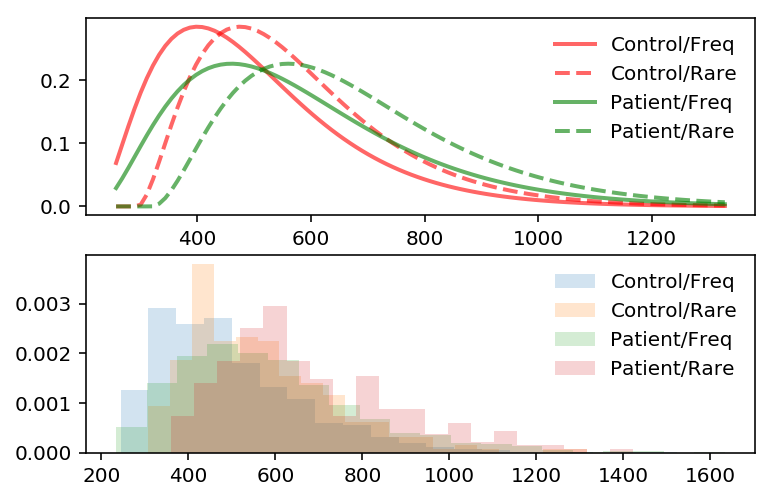

In [5]:
fig, axs = plt.subplots(2, 1)

# These are chosen empirically to generate sane RTs
x_shift = 220
x_mult = 100

cols = dict(Patient='g', Control='r')
lins = dict(Freq='-', Rare='--')
# For plotting
x = np.linspace(gamma.ppf(0.01, *gam_pars['Control']['Freq']),
                gamma.ppf(0.99, *gam_pars['Patient']['Rare']), 100)

RTs = {}
ax = axs[0]
for sub in gam_pars.keys():
    for cond in ['Freq', 'Rare']:
        lab = sub + '/' + cond
        ax.plot(x_shift + x_mult * x, gamma.pdf(x, *gam_pars[sub][cond]),
               cols[sub], ls=lins[cond], lw=2, alpha=0.6, label=lab)
        RTs.setdefault(sub, {}).update(
                       {cond: gamma.rvs(*gam_pars[sub][cond],
                                        size=int(probs[cond] * n_trials))
                     * x_mult + x_shift})
        
ax.legend(loc='best', frameon=False)

ax = axs[1]
for sub in gam_pars.keys():
    for cond in ['Freq', 'Rare']:
        lab = sub + '/' + cond
        ax.hist(RTs[sub][cond], bins=20, normed=True,
                histtype='stepfilled', alpha=0.2, label=lab)
        print('{:s}\tmedian = {:.1f} [{:.1f}, {:.1f}]'
              .format(lab, np.median(RTs[sub][cond]),
                      np.min(RTs[sub][cond]), np.max(RTs[sub][cond])))

ax.legend(loc='best', frameon=False)
plt.show()

## Create logfile data

In [6]:
# calculate time in 100 us steps
# 1-3 sec start delay
start_time = np.random.randint(1e4, 3e4)
# Modify ISI a little from paper: accomodate slightly longer tails
# of the simulated distributions (up to about 1500 ms)
ISI_ran = (1.5e4, 1.9e4)

freq_stims = string.ascii_lowercase
rare_stims = string.digits

### Create subject IDs

In [7]:
# ctrl_NUMs = list(np.random.randint(10, 60, size=2 * subs_per_group))
ctrl_NUMs = list(random.sample(range(10, 60), 2 * subs_per_group))
pat_NUMs = sorted(random.sample(ctrl_NUMs, subs_per_group))
ctrl_NUMs = sorted([c for c in ctrl_NUMs if not c in pat_NUMs])

IDs = dict(Control=['{:04d}_{:s}'.format(n, ''.join(random.choices(
                    string.ascii_uppercase, k=3))) for n in ctrl_NUMs],
           Patient=['{:04d}_{:s}'.format(n, ''.join(random.choices(
                    string.ascii_uppercase, k=3))) for n in pat_NUMs])

### Write subject ID codes to a CSV file

In [8]:
with open(os.path.join(logs_autogen, 'subj_codes.csv'), 'wt') as fp:
    csvw = csv.writer(fp, delimiter=';')
    for stype in IDs.keys():
        for sid in IDs[stype]:
            csvw.writerow([sid, stype])

### Write logfiles

In [10]:
# Write to empty logs dir
if not os.path.exists(logs_autogen):
    os.makedirs(logs_autogen)
for f in glob.glob(os.path.join(logs_autogen, '*.log')):
    os.remove(f)

for stype in ['Control', 'Patient']:
    for sid in IDs[stype]:
        log_date = random_date(*logfile_date_range)
        log_fname = '{:s}_{:s}.log'.format(sid, log_date.isoformat())
        
        with open(os.path.join(logs_autogen, log_fname), 'wt') as log_fp:
            log_fp.write('# Original filename: {:s}\n'.format(log_fname))
            log_fp.write('# Time unit: 100 us\n')
            log_fp.write('# RARECAT=digit\n')
            log_fp.write('#\n')
            log_fp.write('# Time\tHHGG\tEvent\n')

            reacts = np.r_[RTs[stype]['Freq'], RTs[stype]['Rare']]
            # no need to shuffle ITIs...
            itis = np.random.randint(*ISI_ran, size=len(reacts))

            n_freq = len(RTs[stype]['Freq'])
            n_rare = len(RTs[stype]['Rare'])
            n_resps = n_freq + n_rare

            resps = np.random.choice([0, 1], p=[1 - accuracy[stype]['Rare'],
                                                accuracy[stype]['Rare']],
                                     size=n_resps)

            # this only works in python 3.6
            freq_s = random.choices(freq_stims, k=n_freq)
            # for older python:
            # random.choice(string.ascii_uppercase) for _ in range(N)
            rare_s = random.choices(rare_stims, k=n_rare)

            stims = np.r_[freq_s, rare_s]

            resps = np.r_[np.random.choice([0, 1], p=[1 - accuracy[stype]['Freq'],
                                                      accuracy[stype]['Freq']],
                                           size=n_freq),
                         np.random.choice([0, 1], p=[1 - accuracy[stype]['Rare'],
                                                      accuracy[stype]['Rare']],
                                           size=n_rare)]
            corr_answs = np.r_[np.ones(n_freq, dtype=np.int),
                               2*np.ones(n_rare, dtype=np.int)]

            # This shuffles the lists together...
            tmp = list(zip(reacts, stims, resps, corr_answs))
            np.random.shuffle(tmp)
            reacts, stims, resps, corr_answs = zip(*tmp)

            assert len(resps) == len(stims)

            prev_present, prev_response = start_time, -1
            for rt, iti, stim, resp, corr_ans in \
                     zip(reacts, itis, stims, resps, corr_answs):


                # This is needed to ensure that the present response time
                # exceeds the previous response time (plus a little buffer)
                # Slightly skews (truncates) the distribution, but what the hell
                pres_time = max([prev_present + iti,
                                 prev_response + 100])
                resp_time = pres_time + int(10. * rt)

                prev_present = pres_time
                prev_response = resp_time
                log_fp.write('{:d}\t42\tSTIM={:s}\n'.format(pres_time, stim))
                if resp == 0 and corr_ans == 1:
                    answ = 2
                elif resp == 0 and corr_ans == 2:
                    answ = 1
                else:
                    answ = corr_ans
                log_fp.write('{:d}\t42\tRESP={:d}\n'.format(resp_time, answ, resp))